<a href="https://colab.research.google.com/github/AfsanehShamsaddini/Titanic_Survival_Prediction/blob/main/Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Data Collection & Processing


In [129]:
#  Load the data from csv fole to Pandas Dataframe
titanic_data = pd.read_csv('/content/drive/MyDrive/ML/Titanic /train.csv')

In [130]:
# printing the first 5 rows of the Dataframe
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [131]:
# Numbers of rows and columns
titanic_data.shape

(891, 12)

In [132]:
# Getting some information about data
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [133]:
# Check the number of missing values in each column
titanic_data.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


## Handeling the Missing values

In [134]:
# Drop the "Cabin" column from the Dataframe
titanic_data = titanic_data.drop(columns= 'Cabin', axis=1)

In [135]:
# Replasing the missing values in "Age" column with mean value
titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace=True)

/tmp/ipython-input-135-1892719311.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace=True)


In [136]:
# Finding the mode value of "Embarked" column
print(titanic_data['Embarked'].mode())
print(titanic_data['Embarked'].mode()[0])

0    S
Name: Embarked, dtype: object
S


In [137]:
# Replacing the missing value in "Embarked" column with mode value
titanic_data['Embarked'].fillna(titanic_data['Embarked'].mode()[0], inplace=True)

/tmp/ipython-input-137-286567959.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data['Embarked'].fillna(titanic_data['Embarked'].mode()[0], inplace=True)


In [138]:
# Check the number of missing values in each column
titanic_data.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


## Data Analysis

In [139]:
# Getting some statistical measures about the data
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [140]:
# Finding the number of people survived and not survived
titanic_data['Survived'].value_counts()

,count
Survived,
0,549
1,342


## Data Visualization

In [141]:
sns.set()

<Axes: xlabel='Survived', ylabel='count'>

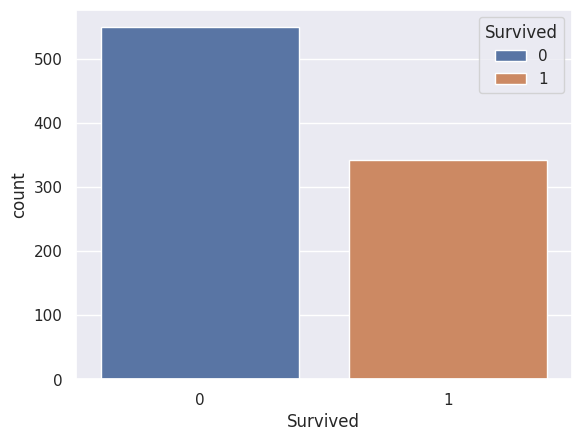

In [142]:
# Making a count plot for "Survived" column
sns.countplot(x='Survived', data=titanic_data, hue= 'Survived')

In [143]:
titanic_data['Sex'].value_counts()

,count
Sex,
male,577
female,314


<Axes: xlabel='Sex', ylabel='count'>

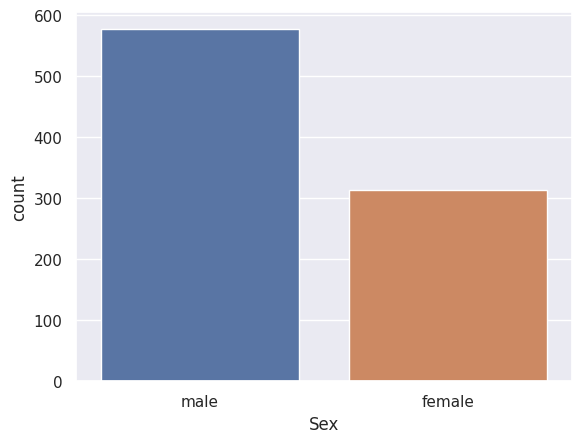

In [144]:
sns.countplot(x= 'Sex', data= titanic_data, hue='Sex')

<Axes: xlabel='Sex', ylabel='count'>

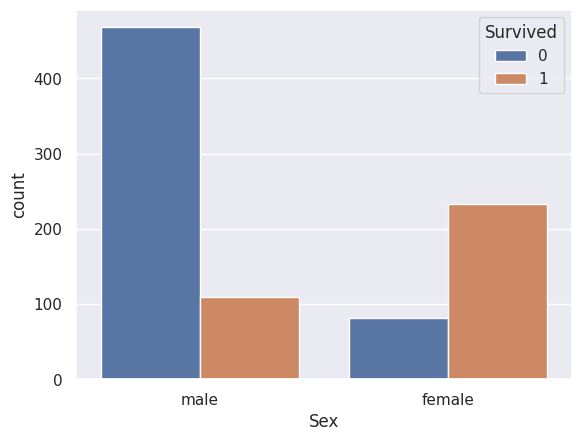

In [145]:
# Number of Survived Gender wise
sns.countplot(x = 'Sex', data = titanic_data, hue= 'Survived')

<Axes: ylabel='count'>

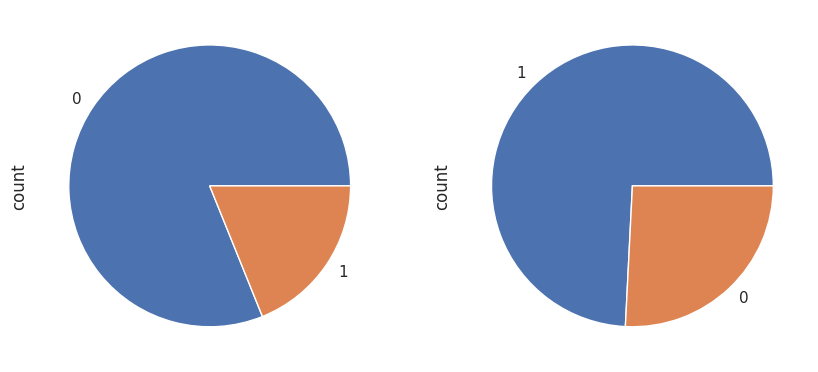

In [146]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(121)
titanic_data.Survived[titanic_data['Sex'] == 'male'].value_counts().plot(kind='pie')
fig.add_subplot(122)
titanic_data.Survived[titanic_data['Sex'] == 'female'].value_counts().plot(kind='pie')

<Axes: xlabel='Pclass', ylabel='count'>

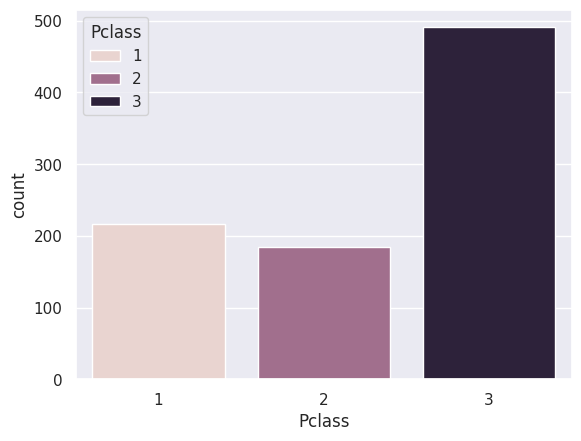

In [147]:
# Making a count plot for "Pclass" column
sns.countplot(x= 'Pclass', data = titanic_data, hue='Pclass')

<Axes: xlabel='Pclass', ylabel='count'>

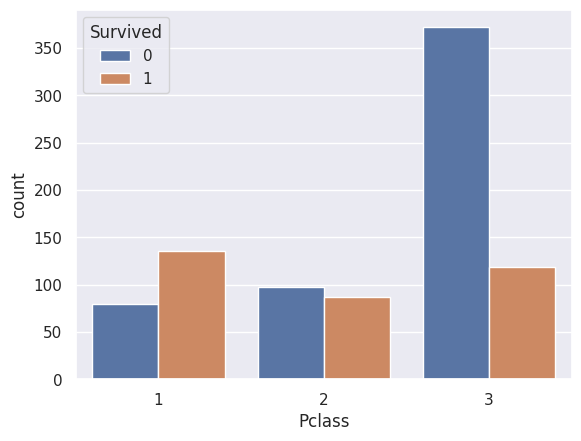

In [148]:
sns.countplot(x='Pclass', data= titanic_data, hue='Survived')

## Encoding the Categorical Columns

In [149]:
titanic_data['Sex'].value_counts()

,count
Sex,
male,577
female,314


In [150]:
titanic_data['Embarked'].value_counts()

,count
Embarked,
S,646
C,168
Q,77


In [151]:
# Converting categorical columns
titanic_data.replace({
    'Sex':{'male':0,
            'female':1},
    'Embarked':{
        'S':0,
        'C':1,
        'Q':2
    }
}, inplace=True)

/tmp/ipython-input-151-2063304941.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  titanic_data.replace({


In [152]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0


## Separating Features & Targets

In [153]:
X= titanic_data.drop(columns=['PassengerId', 'Name', 'Ticket','Survived'], axis=1)
Y = titanic_data['Survived']

In [154]:
print(X)

     Pclass  Sex        Age  SibSp  Parch     Fare  Embarked
0         3    0  22.000000      1      0   7.2500         0
1         1    1  38.000000      1      0  71.2833         1
2         3    1  26.000000      0      0   7.9250         0
3         1    1  35.000000      1      0  53.1000         0
4         3    0  35.000000      0      0   8.0500         0
..      ...  ...        ...    ...    ...      ...       ...
886       2    0  27.000000      0      0  13.0000         0
887       1    1  19.000000      0      0  30.0000         0
888       3    1  29.699118      1      2  23.4500         0
889       1    0  26.000000      0      0  30.0000         1
890       3    0  32.000000      0      0   7.7500         2

[891 rows x 7 columns]


In [155]:
print(Y)

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64


## Splitting the data into Traning data & Test data

In [156]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

In [157]:
print(X.shape, x_train.shape, x_test.shape)

(891, 7) (712, 7) (179, 7)


## Model Training

### Logistic Regression

In [158]:
model = LogisticRegression()

In [ ]:
# Training the Logestic Regression model with training data
model.fit(x_train, y_train)

## Model Evaluation

### Accuracy Score

In [160]:
# Accuracy on traning data
y_train_pred = model.predict(x_train)

In [161]:
print(y_train_pred)

[0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1
 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0
 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1
 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0
 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1
 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0
 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0
 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0
 0 0 0 0 1 0 0 1 0 1 1 0 

In [162]:
training_data_acc = accuracy_score(y_train, y_train_pred)
print(f"Accuracy on training data: {training_data_acc}")

Accuracy on training data: 0.8075842696629213


In [163]:
# Accuracy on test data
y_test_pred = model.predict(x_test)

In [164]:
print(y_test_pred)

[0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0
 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0
 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0
 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0]


In [165]:
test_data_acc = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on test data: {test_data_acc}")

Accuracy on test data: 0.7821229050279329


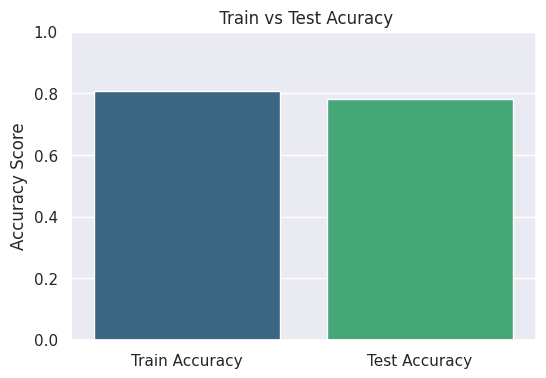

In [166]:
accuracy_scores = {
    'Train Accuracy': training_data_acc,
    'Test Accuracy': test_data_acc
}

plt.figure(figsize=(6, 4))
sns.barplot(x= list(accuracy_scores.keys()), y= list(accuracy_scores.values()), hue = list(accuracy_scores.keys()), palette = 'viridis')
plt.title(' Train vs Test Acuracy')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.show()

## Model Training


## XGBoost

In [167]:
XGBoost_model = XGBClassifier()

In [ ]:
XGBoost_model.fit(x_train, y_train)

## Model Evaluation

### Accuracy Score

In [169]:
# Accuracy on traning data
y_train_pred_xgboost = model.predict(x_train)

In [170]:
print(y_train_pred_xgboost)

[0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1
 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0
 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1
 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0
 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1
 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0
 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0
 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0
 0 0 0 0 1 0 0 1 0 1 1 0 

In [171]:
training_data_acc_xgboost = accuracy_score(y_train, y_train_pred_xgboost)
print(f"Accuracy on training data: {training_data_acc_xgboost}")

Accuracy on training data: 0.8075842696629213


In [172]:
# Accuracy on test data
y_test_pred_xgboost = model.predict(x_test)

In [173]:
print(y_test_pred_xgboost)

[0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0
 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0
 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0
 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0]


In [174]:
test_data_acc_xgboost = accuracy_score(y_test, y_test_pred_xgboost)
print(f"Accuracy on test data: {test_data_acc_xgboost}")

Accuracy on test data: 0.7821229050279329


## Model Training

## Decision Tree

In [175]:
tree_model = DecisionTreeClassifier()

In [ ]:
tree_model.fit(x_train, y_train)

## Model Evaluation

### Accuracy Score

In [177]:
# Accuracy on traning data
y_train_pred_tree = model.predict(x_train)

In [178]:
print(y_train_pred_tree)

[0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1
 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0
 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1
 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0
 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1
 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0
 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0
 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0
 0 0 0 0 1 0 0 1 0 1 1 0 

In [179]:
training_data_acc_tree = accuracy_score(y_train, y_train_pred_tree)
print(f"Accuracy on training data: {training_data_acc_tree}")

Accuracy on training data: 0.8075842696629213


In [180]:
# Accuracy on test data
y_test_pred_tree = model.predict(x_test)

In [181]:
print(y_test_pred_tree)

[0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0
 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0
 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0
 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0]


In [182]:
test_data_acc_tree = accuracy_score(y_test, y_test_pred_tree)
print(f"Accuracy on test data: {test_data_acc_tree}")

Accuracy on test data: 0.7821229050279329


## Model Training

## Random Forest

In [183]:
model_forest= RandomForestClassifier()

In [ ]:
model_forest.fit(x_train, y_train.squeeze())

## Model Evaluation

### Accuracy Score

In [192]:
# Accuracy on traning data
y_train_pred_forest = model.predict(x_train)

In [193]:
print(y_train_pred_forest)

[0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1
 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0
 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1
 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0
 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1
 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0
 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0
 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0
 0 0 0 0 1 0 0 1 0 1 1 0 

In [194]:
training_data_acc_forest = accuracy_score(y_train, y_train_pred_forest)
print(f"Accuracy on training data: {training_data_acc_forest}")

Accuracy on training data: 0.8075842696629213


In [195]:
# Accuracy on test data
y_test_pred_forest = model.predict(x_test)

In [196]:
print(y_test_pred_forest)

[0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0
 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0
 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0
 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0]


In [197]:
test_data_acc_forest = accuracy_score(y_test, y_test_pred_forest)
print(f"Accuracy on test data: {test_data_acc_forest}")

Accuracy on test data: 0.7821229050279329


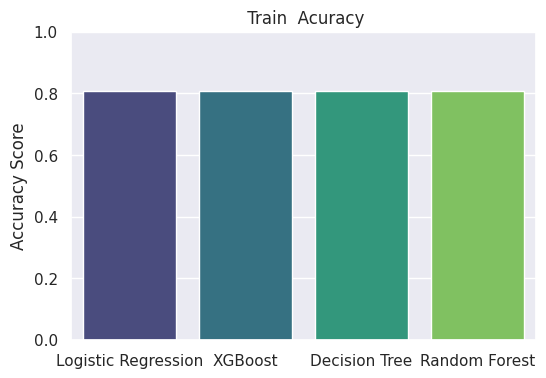

In [199]:
train_accuracy_scores = {
    'Logistic Regression': training_data_acc,
    'XGBoost': training_data_acc_xgboost,
    'Decision Tree': training_data_acc_tree,
    'Random Forest': training_data_acc_forest
}

plt.figure(figsize=(6, 4))
sns.barplot(x= list(train_accuracy_scores.keys()), y= list(train_accuracy_scores.values()), hue = list(train_accuracy_scores.keys()), palette = 'viridis')
plt.title(' Train  Acuracy')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.show()

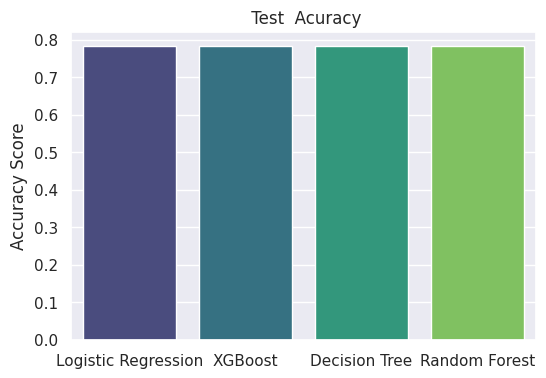

In [201]:
test_accuracy_scores = {
    'Logistic Regression': test_data_acc,
    'XGBoost': test_data_acc_xgboost,
    'Decision Tree': test_data_acc_tree,
    'Random Forest': test_data_acc_forest
}

plt.figure(figsize=(6, 4))
sns.barplot(x= list(test_accuracy_scores.keys()), y= list(test_accuracy_scores.values()), hue = list(test_accuracy_scores.keys()), palette = 'viridis')
plt.title(' Test  Acuracy')
plt.ylabel('Accuracy Score')
# plt.ylim(0, 1)
plt.show()